In [ ]:
## This is a series of examples demonstrating the use of the icanswim/cosmosis repo 
## for data science and machine learning projects.
## This repo is intended to be used as the boiler plate for data science and machine learning projects.
## See the icanswim/qchem repo for a demonstration of the use of this (icanswim/cosmosis) repo.

In [1]:
from model import FFNet, tv_model, IdentityModel, GPT
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS, ExampleDataset
from dataset import ImageDatasetStats, AsTensor, SqueezeN, DType, Pad1d, EmbedLookup, Reshape

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

import numpy as np


In [ ]:
#Cosmosis blank parameters

lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
ds_param = {'train_param': {'input_dict': {'X': ['feature_1','feature_2'],
                                           'feature_3': ['feature_3']},
                            'transforms': {'feature_1': [ExampleTransform(10), AsTensor()],
                                           'feature_2': [Reshape(-1), AsTensor()],
                                           'feature_3': [Pad1d(5), EmbedLookup(lookup_feature_3), AsTensor()]},
                            'boom': 'bang'}}

model_param = {'some_param': 128,
               'X': None,
               'y': 'y',
               'embed_param': {'feature_3': (voc,vec,padding_idx,trainable),
                               'some_param': True,
                               'flatten': True}} 
                                       
metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} #break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([DS], 
              Model,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Optimizer, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=LossFunction,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=12, epochs=1, gpu=True)


In [2]:
#example cosmosis dataset (CDataset)

class ExampleTransform():
    def __init__(self, num):
        self.num = num
        
    def __call__(self, arr):
        return np.add(arr, self.num)


class ExampleDataset(CDataset):
    #zero is the lookup for the padding index 
    embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                    'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0},
                    'feature_6': {'e': 1, 'f': 2, 'g': 3, '0': 0}}
    
    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([[.02,.03],[.04,.05]]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1]),
                       'feature_6': np.asarray(['e','f','g'])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([[.1,.2],[.3,.4]]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2]),
                       'feature_6': np.asarray(['f','f','g'])}}
        
        print(boom)
        return datadic
    
lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
lookup_feature_4 = ExampleDataset.embed_lookup['feature_4']
lookup_feature_6 = ExampleDataset.embed_lookup['feature_6']
ds_param = {'train_param': {'input_dict': {
                                           'X2': ['feature_1','feature_2'], 
                                           'X3': ['feature_2'],
                                           'embed_3': ['feature_3'],
                                           'embed_4': ['feature_4'],
                                           'target': ['feature_5'],
                                            },
                            'transforms': {'feature_1': [ExampleTransform(10), Reshape((-1)), AsTensor()],
                                           'feature_2': [Reshape((-1)), AsTensor()],
                                           'feature_3': [Pad1d(5), EmbedLookup(lookup_feature_3), AsTensor()],
                                           'feature_4': [Pad1d(5), EmbedLookup(lookup_feature_4), AsTensor()],
                                           'feature_5': [AsTensor()],
                                           'feature_6': [Pad1d(5), EmbedLookup(lookup_feature_6), AsTensor()]},
                            'boom': 'bang'}}
    
ed = ExampleDataset(**ds_param['train_param'])
print('ed[1]: ', ed[1])

model_param = {'device': 'cpu',
               'X': ['X2', 'X3'],
               'y': 'target',
               'embed_param': {'embed_3': (4,8,0,False),
                               'embed_4': (5,8,0,False),
                               'flatten': True}}

im = IdentityModel(model_param)
print(im)
print('embedding_layer: ', im.embedding_layer)

out = im(ed[1])
print('out: ', out)
print('out.shape: ', out.shape) # (1+4+4+5*8+5*8) = 89


bang
CDataset created...
ed[1]:  {'X2': tensor([10.0400,  0.0200,  0.0300,  0.0400,  0.0500], dtype=torch.float64), 'X3': tensor([0.0200, 0.0300, 0.0400, 0.0500], dtype=torch.float64), 'embed_3': tensor([1, 0, 0, 0, 0]), 'embed_4': tensor([3, 3, 4, 0, 0]), 'target': tensor([1.1000], dtype=torch.float64)}
CModel loaded...
IdentityModel(
  (layers): ModuleList(
    (0): Identity()
  )
)
embedding_layer:  {'embed_3': Embedding(4, 8, padding_idx=0), 'embed_4': Embedding(5, 8, padding_idx=0)}
X.shape:  torch.Size([9])
embedded.shape:  torch.Size([80])
out:  tensor([10.0400,  0.0200,  0.0300,  0.0400,  0.0500,  0.0200,  0.0300,  0.0400,
         0.0500, -0.8005,  0.1714,  0.2802, -0.7274,  1.1728,  1.1332, -1.3666,
         0.0933,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.000

In [3]:
#example showing transformer inputs, outputs and parameters
#example sequence translation using GPT like decoder only transformer model

lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
lookup_feature_4 = ExampleDataset.embed_lookup['feature_4']
ds_param = {'train_param': {'input_dict': {'X1': ['feature_3'], # target
                                           'X2': ['feature_4']},
                            'transforms': {'feature_3': [Pad1d(6), EmbedLookup(lookup_feature_3), AsTensor()],
                                           'feature_4': [Pad1d(6), EmbedLookup(lookup_feature_4), AsTensor()]},
                              'boom': 'bang'}}
    
ed = ExampleDataset(**ds_param['train_param'])
print('ed[1]: ', ed[1])

model_param = {'device': 'cpu',
               'd_model': 8, # matches embedding dimension
               'n_head': 2, 
               'num_layers': 2,
               'd_vocab': 4, # determines the linear_head dim
               'linear_head': True,
               'probs': True, # returns normalized probs or logits
               'tokens': True, # returns tokens
               'transpose': False,
               'embed_param': {'X1': (4,8,0,True), # embed key matches input_dict key ('X1')
                               'X2': (5,8,0,True), # vector dimension matches d_model dimension
                } 
              }                                  
                 
                                 
gpt = GPT(model_param)
print(gpt)
print('embedding_layer: ', gpt.embedding_layer)
out = gpt(ed[1])
print('out: ', out)
print('out.shape: ', out.shape) 
# (feature_length, embedding_lenth) x (linear_head, d_vocab) = (6, 8) x (8, 4) = (6 x 4)

inverse_lookup_feature_3 = {v: k for k, v in lookup_feature_3.items()}
for generated_token in out.squeeze().tolist():
    generated_symbol = inverse_lookup_feature_3[generated_token]
    print(generated_symbol)

inverse_lookup_feature_4 = {v: k for k, v in lookup_feature_4.items()}
for prompt_token in ed[1]['X2'].tolist():
    symbol = inverse_lookup_feature_4[prompt_token]
    print(symbol)
    
                        

bang
CDataset created...
ed[1]:  {'X1': tensor([1, 0, 0, 0, 0, 0]), 'X2': tensor([3, 3, 4, 0, 0, 0])}
CModel loaded...
GPT(
  (linear_head): Sequential(
    (0): Linear(in_features=8, out_features=4, bias=True)
    (1): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (linear1): Linear(in_features=8, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=8, bias=True)
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((8,), eps=1e-

In [4]:
#example cosmosis sklearn regression dataset wrapper (SKDS)
                            
ds_param = {'train_param': {'input_dict': {'model_input': ['X'],
                                           'y': ['y']},
                            'dataset': 'make_regression',
                            'sk_param': {'n_samples': 100,
                                         'n_features': 5},
                            'features_dtype': 'float32',
                            'targets_dtype': 'float32'}}

sk = SKDS(**ds_param['train_param'])

sk[1]


creating scikit learn make_regression dataset...
CDataset created...


{'model_input': array([ 0.2464928 ,  0.39951667, -0.48289862,  0.6721777 , -0.5789743 ],
       dtype=float32),
 'y': array([28.917461], dtype=float32)}

In [5]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'transforms': {'y': [AsTensor()],
                                           'X': [AsTensor()]},
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 1000,
                                         'n_features': 30,
                                         'n_informative': 20,
                                         'n_clusters_per_class': 3,
                                         'flip_y': 0.05,
                                         'class_sep': 0.1,
                                         'n_classes': 4}}}

sk = SKDS(**ds_param['train_param'])

print(sk[1])


creating scikit learn make_classification dataset...
CDataset created...
{'X': tensor([ 0.2489, -4.5445,  0.7022, -1.5402, -0.4997,  1.3403, -0.9325, -0.6535,
        -0.3606,  0.0142, -0.1619, -0.0319, -2.8610,  1.1807, -0.9305, -1.4250,
        -2.7121, -4.6140,  1.2317, -0.3892, -0.4814, -1.0122, -3.2877,  0.7837,
         1.4215, -1.6578, -0.5296, -0.6184,  1.8195, -2.4573]), 'y': tensor([1])}


In [6]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_param = {'train_param': {'input_dict': {'features': ['images'],
                                           'y': ['labels']},
                            'dataset': 'MNIST',
                            'tv_param': {'root': './data/',
                                         'train': True,
                                         'download': True,
                                         'transform': transforms.Compose([transforms.Resize(224)]),
                                         'target_transform': None}}}

tvds = TVDS(**ds_param['train_param'])
tvds[1]


creating torch vision MNIST dataset...
CDataset created...


{'image': <PIL.Image.Image image mode=L size=224x224>, 'y': 0}

In [7]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_param={'dataset': 'MNIST',
          'tv_param': {'root': './data/',
                       'train': True,
                       'download': True,
                       'transform': transforms.Compose([transforms.Resize(224)]),
                       'target_transform': None}}

tvds = TVDS(**ds_param)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
self.y_pred[-1]:  tensor([[  260.2856],
        [ -956.6909],
        [  823.4749],
        [ -480.2729],
        [ 1335.0291],
        [ -160.2440],
        [  393.3657],
        [  673.2585],
        [ 1366.8265],
        [ -643.1564],
        [  -64.3688],
        [  110.7172],
        [-1002.6127],
        [-1105.6605],
        [ -783.9601],
        [  133.6282],
        [ -718.9706],
        [  230.2772],
        [  404.9068],
        [  234.1494],
        [ 1049.2842],
        [  761.6023],
        [  935.5916],
        [ -341.7521],
        [ -604.5093],
        [ -471.6754],
        [-1064.8733],
        [ 1396.4871],
        [ 2755.5212],
        [  562.4109],
        [-1240.8918],
        [ 1218.9170],
        [  225.9092],
        [-1997.3160],
        [  217.6745],
        [ -638.3484],
        [  274.1755],
        [  167.7924],
        [ -883

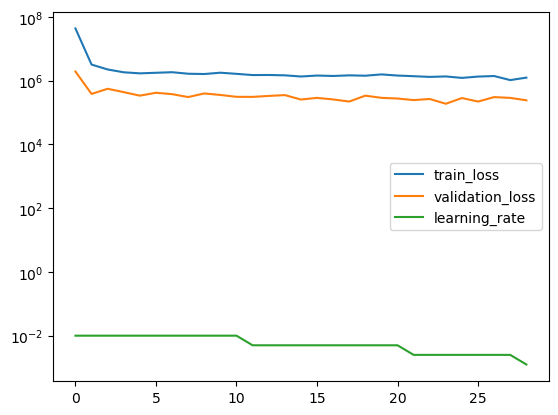


 early stopping!  learning rate is below the set minimum...
total learning time: 0:00:14.521124 

test loss: 287156.423828125 



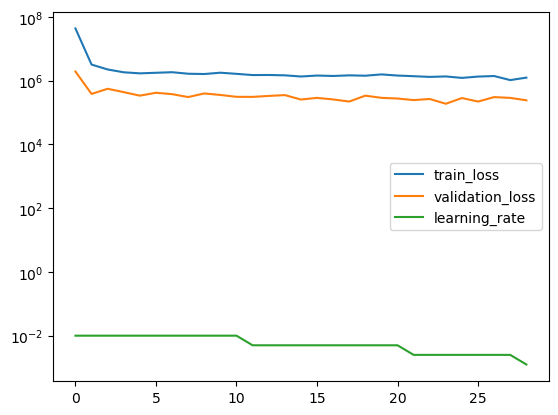

In [2]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_param = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'float32',
                            'dataset': 'make_regression',
                            'sk_param': {'n_samples':20000,
                                         'n_features': 256,
                                         'n_informative': 200}}}
             
metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .00125} #break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 3,
               'cooldown': 3}

learn = Learn([SKDS], 
              FFNet,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=MSELoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=128, epochs=50, gpu=True)


creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
self.y_pred[-1]:  tensor([[ 2.3838e+00, -2.4888e+00,  4.3868e-01, -2.0066e+00],
        [ 2.3472e+00, -1.9214e+00, -5.5845e-02, -1.9412e+00],
        [-9.7107e-02, -7.3979e-01, -1.6514e+00,  1.4878e+00],
        [ 2.4735e+00, -7.6232e-01, -5.6074e-01, -2.3084e+00],
        [-1.8705e+00, -1.3470e+00, -2.2890e-01,  2.5178e+00],
        [-1.5490e-01, -1.1318e+00,  1.8533e+00, -1.7784e+00],
        [-2.3098e+00,  6.7951e-01, -1.4253e+00,  2.2674e+00],
        [ 3.3405e-01,  1.8219e+00, -1.0566e+00, -1.5496e+00],
        [-3.3360e-01, -2.5728e-01, -4.2835e-01,  6.2637e-01],
        [-4.2320e-01, -3.0981e+00,  4.8816e-01,  1.9690e+00],
        [ 1.4440e+00, -1.9440e+00,  1.0214e+00, -1.9394e+00],
        [ 1.6304e+00, -2.0146e+00, -4.2908e-01, -5.9142e-02],
        [ 8.9129e-01, -1.9708e+00,  1.7176e+00, -2.2279e+00],
        [-1.9379e+00,  2.6042e+00, -3.07

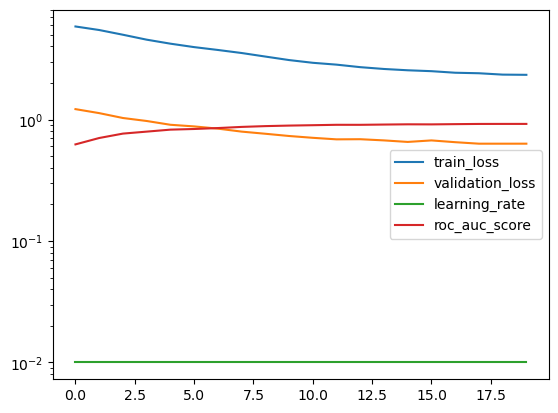

In [2]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_param = {'in_channels': 256, 
               'hidden': 128, 
               'out_channels': 4,
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'transforms': {'y': [SqueezeN()],
                                           'X': []},
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 100000,
                                         'n_features': 300,
                                         'n_informative': 200,
                                         'n_redundant': 5,
                                         'n_repeated': 5,
                                         'n_clusters_per_class': 5,
                                         'flip_y': 0.05,
                                         'class_sep': 0.05,
                                         'n_classes': 4}}}
                                     
metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'metric_name': 'roc_auc_score',
                 'metric_param': {'average': 'macro',
                                  'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .5,
               'patience': 2,
               'cooldown': 1}

learm = Learn([SKDS], 
              FFNet, 
              Sampler=Selector,
              Metrics=Metrics,
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, 
              sample_param=sample_param, opt_param=opt_param, 
              sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param,
              adapt=(300,256,.2), batch_size=128, epochs=20, 
              save_model='demo_model')


In [9]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)

model_param = {'in_channels': 256, 
               'hidden': 128, 
               'out_channels': 4, 
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 10000,
                                         'n_features': 300,
                                         'n_informative': 200,
                                         'n_clusters_per_class': 3,
                                         'flip_y': 0.05,
                                         'class_sep': 0.1,
                                         'n_classes': 4}}}
                                     
learn = Learn([SKDS], 
              FFNet, 
              Sampler=Selector,
              Metrics=Metrics,
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=None,
              model_param=model_param, ds_param=ds_param, 
              batch_size=128, epochs=2, load_model='demo_model.pth')


creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...

...........................
learning time: 0:00:00.342094
last predictions: 
[[-2.3009644   0.475334    1.3049836   0.10165276]
 [ 0.07463032  0.4837711   1.1796197  -2.4347403 ]
 [-0.01115358  1.3161129  -3.5118256   0.7285417 ]
 ...
 [ 1.5458729  -1.3466206  -0.15546736 -1.193177  ]
 [-0.99330664  2.737046   -2.3509786  -1.1882905 ]
 [-2.2626016   1.057829   -0.27341712  0.77774405]]

inference 2024-12-31 08:41:50.633333 complete and saved to csv...


In [10]:
learn.metrics.predictions

array([[-1.6782973 , -0.95652825,  1.1530209 ,  1.062238  ],
       [ 2.3163493 , -1.6572894 , -2.3610654 , -0.37721577],
       [-0.20709318,  2.4724493 , -1.7888347 , -1.8221735 ],
       ...,
       [ 1.5458729 , -1.3466206 , -0.15546736, -1.193177  ],
       [-0.99330664,  2.737046  , -2.3509786 , -1.1882905 ],
       [-2.2626016 ,  1.057829  , -0.27341712,  0.77774405]],
      dtype=float32)

creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...

...........................
learning time: 0:00:06.596790
epoch: 0, lr: 0.01
train loss: 2.2060471472740173, val loss: 1.9044808553111168

last targets: 
[9 1 0 0 4]

last predictions: 
[[0.09738773 0.03427333 0.08723671 ... 0.14795604 0.04816016 0.06359371]
 [0.03977175 0.02710945 0.09287733 ... 0.28580186 0.01839843 0.02200038]
 [0.03900929 0.00926808 0.08581043 ... 0.5305137  0.0078001  0.01559068]
 ...
 [0.12304424 0.02926835 0.09543141 ... 0.11584463 0.06606831 0.05831448]
 [0.12783976 0.20259075 0.06850955 ... 0.05326137 0.08862646 0.10752115]
 [0.03472444 0.01119199 0.16248651 ... 0.14527434 0.01181301 0.01229335]]

roc_auc_score train score: 0.6909638921270351, validation score: 0.7892338733768123

........................

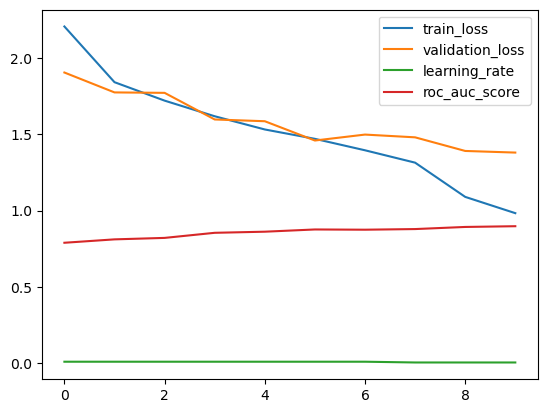

In [11]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_param = {'model_name': 'resnet18',
               'in_channels': 3,
               'tv_param': {'num_classes': 10}}

ds_param={'train_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': True,
                                       'download': True,
                                       'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                       'target_transform': None,
                                       'download': True}},
           'test_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': False,
                                       'download': True,
                                       'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                       'target_transform': None,
                                       'download': True}}}

metrics_param = {'report_interval': 30, 
                 'metric_name': 'roc_auc_score', 
                 'metric_param': {'average': 'macro',
                                  'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.8,),
                'subset': .1}

sched_param = {'factor': .5,
               'patience': 1,
               'cooldown': 1}

learn = Learn([TVDS,TVDS], 
              tv_model, 
              Selector, 
              Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
              model_param=model_param, ds_param=ds_param, sample_param=sample_param, 
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=16, epochs=10)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...

...........................
learning time: 0:01:05.147665
epoch: 0, lr: 0.01
train loss: 2.5674985399246215, val loss: 2.072288857352349

last targets: 
[4 8 8 5 5]

last predictions: 
[[0.07278122 0.14399211 0.07370973 ... 0.11020724 0.09185917 0.11255028]
 [0.01910913 0.05766986 0.08401669 ... 0.13554628 0.02359482 0.05072202]
 [0.0426407  0.14339124 0.06614842 ... 0.11613528 0.06407788 0.10988762]
 ...
 [0.40786144 0.10521875 0.03512064 ... 0.02700499 0.28703937 0.07597713]
 [0.03897474 0.1277065  0.06919663 ... 0.11989995 0.0569594  0.1019728 ]
 [0.02523606 0.05075788 0.09442572 ... 0.13529946 0.02689966 0.04796572]]

roc_auc_score train score: 0.6063433975820386, validation score: 0.7021178663628574

...........................
learning time: 0:02:08.900400
epoch: 1, lr: 0.01
train loss: 2.066

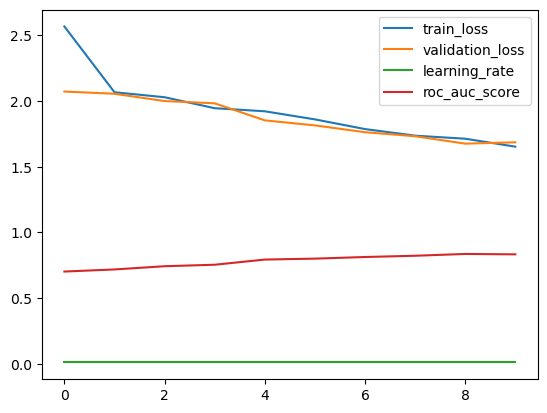

In [2]:
#example cosmosis torchvision dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_param = {'model_name': 'resnext50_32x4d',
               'in_channels': 3,
               'tv_param': {'num_classes': 10}}

ds_param={'train_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': True,
                                       'transform': transforms.Compose([
                                                    transforms.RandomRotation(10),
                                                    transforms.Resize(256),
                                                    transforms.ToTensor()]),
                                       'target_transform': None}},
           'test_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': False,
                                       'transform': transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.ToTensor()]),
                                       'target_transform': None}}}

metrics_param = {'report_interval': 60, 
                 'metric_name': 'roc_auc_score', 
                 'metric_param': {'average': 'macro',
                                  'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.8,),
                'subset': .1}

sched_param = {'factor': .5,
               'patience': 2,
               'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_param=model_param, ds_param=ds_param, 
          sample_param=sample_param, opt_param=opt_param, 
          sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=16, epochs=10)